<a href="https://colab.research.google.com/github/Raman3022/GenAI/blob/main/Speech_to_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction:**
Bot capable of handling calls involves integrating voice capabilities like real-time speech-to-text (STT)**bold text**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Speech-to-Text (STT): The core task is to convert audio (speech) into written text.

In [2]:
!pip install openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 39.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.0 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803373 sha256=65eec929d61b8862ea6933b0d248ffb747bf9c6cb8e2026b88089cab0f44f29b
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [3]:
!pip install textblob

In [7]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.5 MB/s eta 0:00:00


In [ ]:
import os
import whisper
import time
import csv
from google.colab import drive
from textblob import TextBlob
import soundfile as sf
import spacy
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [11]:
# Load the Whisper model
model = whisper.load_model("base")

# Load spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Load pre-trained emotion detection model from transformers
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

# Path to the folder where the extracted 'dev-clean' directory is located in Google Drive
dataset_path = "/content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean"

# List to hold the paths of all FLAC files
flac_files = []

# Walk through all subdirectories in the dataset path to find FLAC files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".flac"):  # Look for FLAC files
            file_path = os.path.join(root, file)
            flac_files.append(file_path)

# Output the list of FLAC files found
print(f"Found {len(flac_files)} FLAC files.")

# Variables to track timing
total_time = 0.0
timing_data = []

# List to store sentiment analysis results
sentiment_results = []

# Initialize SentimentIntensityAnalyzer (VADER) for sentiment analysis
analyzer = SentimentIntensityAnalyzer()

# Process each FLAC file (transcribe using Whisper)
for file_path in flac_files:
    print(f"Processing {file_path}...")

    # Extract audio duration
    try:
        audio_file = sf.SoundFile(file_path)
        duration = len(audio_file) / audio_file.samplerate
    except Exception as e:
        print(f"Error extracting audio duration for {file_path}: {e}")
        duration = None

    # Start timing
    start_time = time.time()

    # Perform transcription
    try:
        result = model.transcribe(file_path)
        transcription_text = result['text']
        confidence = result.get('segments', [{}])[0].get('avg_logprob', None)  # Extract confidence if available
    except Exception as e:
        print(f"Error during transcription for {file_path}: {e}")
        transcription_text = ""
        confidence = None

    # End timing
    end_time = time.time()

    # Calculate time taken
    time_taken = end_time - start_time
    timing_data.append(time_taken)
    total_time += time_taken

    print(f"Transcription: {transcription_text}")
    print(f"Time taken: {time_taken:.2f} seconds")
    print(f"Audio Duration: {duration:.2f} seconds")
    if confidence is not None:
        print(f"Confidence Score: {confidence:.2f}")

    # Perform sentiment analysis
    sentiment = TextBlob(transcription_text).sentiment
    polarity = sentiment.polarity
    subjectivity = sentiment.subjectivity

    # Perform emotion analysis
    emotion = emotion_pipeline(transcription_text)
    emotion_label = emotion[0]['label'] if emotion else None

    # Perform Named Entity Recognition (NER)
    doc = nlp(transcription_text)
    entities = [ent.text for ent in doc.ents]  # Extract entities

    # Perform VADER Sentiment Analysis
    vader_sentiment = analyzer.polarity_scores(transcription_text)
    sentiment_score = vader_sentiment['compound']  # Compound sentiment score

    word_count = len(transcription_text.split())
    sentiment_results.append({
        "file": file_path,  # Add the file path here
        "duration": duration,
        "text": transcription_text,
        "word_count": word_count,
        "confidence": confidence,
        "polarity": polarity,
        "subjectivity": subjectivity,
        "time_taken": time_taken,
        "entities": ", ".join(entities),
        "intent": "Intent Placeholder",  # Placeholder for intent analysis
        "emotion": emotion_label
    })

    print(f"Word Count: {word_count}")
    print(f"Sentiment Polarity: {polarity:.2f}")
    print(f"Sentiment Subjectivity: {subjectivity:.2f}")
    print(f"Entities: {', '.join(entities)}")
    print(f"Emotion: {emotion_label}")
    print(f"Sentiment Score (VADER): {sentiment_score:.2f}")

# Calculate and output average time
average_time = total_time / len(flac_files) if flac_files else 0
print(f"\nProcessed {len(flac_files)} files.")
print(f"Total time taken: {total_time:.2f} seconds")
print(f"Average time per file: {average_time:.2f} seconds")

# Output sentiment analysis summary
print("\nSentiment Analysis Results:")
for result in sentiment_results:
    print(f"File: {result['file']}")
    print(f"Transcription: {result['text']}")
    print(f"Duration: {result['duration']:.2f} seconds")
    print(f"Word Count: {result['word_count']}")
    print(f"Confidence Score: {result['confidence']}")
    print(f"Polarity: {result['polarity']:.2f}, Subjectivity: {result['subjectivity']:.2f}")
    print(f"Entities: {result['entities']}")
    print(f"Emotion: {result['emotion']}\n")

# Save results to a CSV file
output_csv_path = "/content/drive/MyDrive/transcription_results.csv"
with open(output_csv_path, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=[
        "file", "duration", "text", "word_count", "confidence", "polarity", "subjectivity",
        "time_taken", "entities", "intent", "emotion"
    ])
    writer.writeheader()
    writer.writerows(sentiment_results)

print(f"Results saved to {output_csv_path}")


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
Device set to use cuda:0


Found 2703 FLAC files.
Processing /content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/8842/302201/8842-302201-0005.flac...
Transcription:  And I declare that when I speak thereof, love sheds such perfect sweetness over me, that if my courage failed not, certainly, to him my listeners must be all resigned.
Time taken: 3.35 seconds
Audio Duration: 10.10 seconds
Confidence Score: -0.24
Word Count: 30
Sentiment Polarity: 0.18
Sentiment Subjectivity: 0.59
Entities: 
Emotion: sadness
Sentiment Score (VADER): 0.84
Processing /content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/8842/302201/8842-302201-0007.flac...
Transcription:  To her I went along, in whose much strength my weakness has made strong.
Time taken: 0.32 seconds
Audio Duration: 4.86 seconds
Confidence Score: -0.27
Word Count: 14
Sentiment Polarity: 0.32
Sentiment Subjectivity: 0.47
Entities: 
Emotion: neutral
Sentiment Score (VADER): 0.57
Processing /content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/8842/302201/8842-3022

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Streaming output truncated to the last 5000 lines.
Polarity: 0.00, Subjectivity: 0.10
Entities: 
Emotion: neutral

File: /content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/2086/149220/2086-149220-0030.flac
Transcription:  The sun, as you see, tells quite another story, and will not be coped out of it, after half a dozen patient attempts on my part.
Duration: 8.10 seconds
Word Count: 26
Confidence Score: -0.2277615819658552
Polarity: -0.17, Subjectivity: 0.17
Entities: half a dozen
Emotion: neutral

File: /content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/2086/149220/2086-149220-0021.flac
Transcription:  It is like a bandage over one's eyes to come into it.
Duration: 3.33 seconds
Word Count: 12
Confidence Score: -0.24026041560702854
Polarity: 0.00, Subjectivity: 0.00
Entities: 
Emotion: disgust

File: /content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/2086/149220/2086-149220-0036.flac
Transcription:  It is nonsense said Phoebe a little impatiently for us to talk about a pict

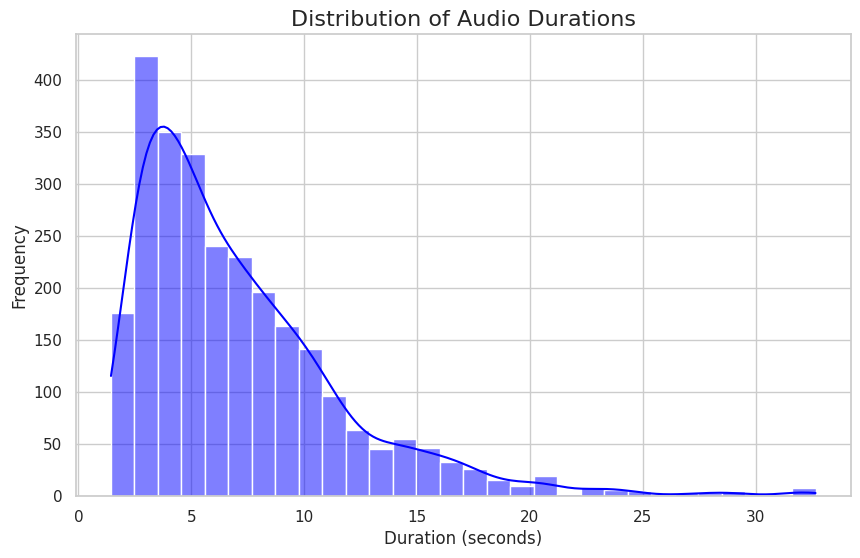

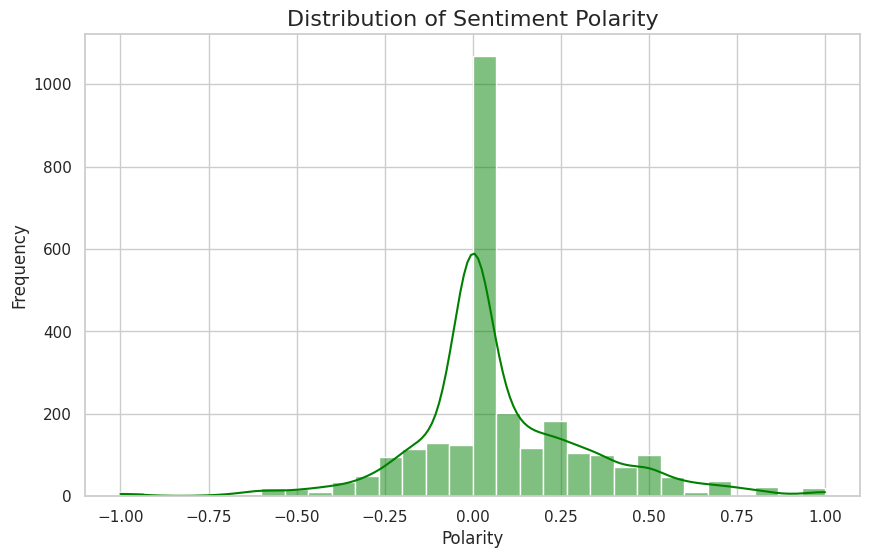

<ipython-input-16-0bfb24c816a2>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


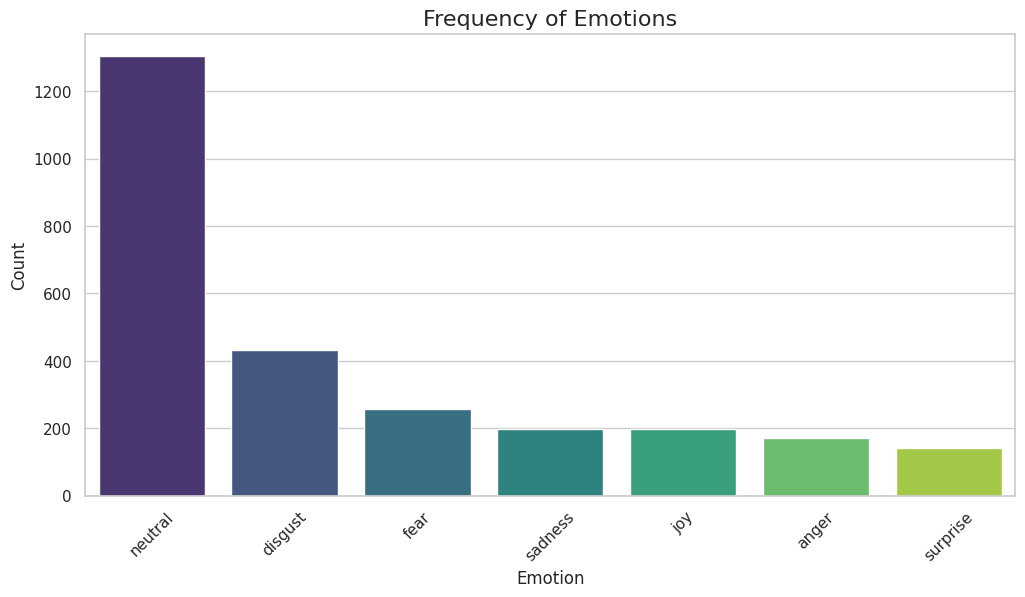

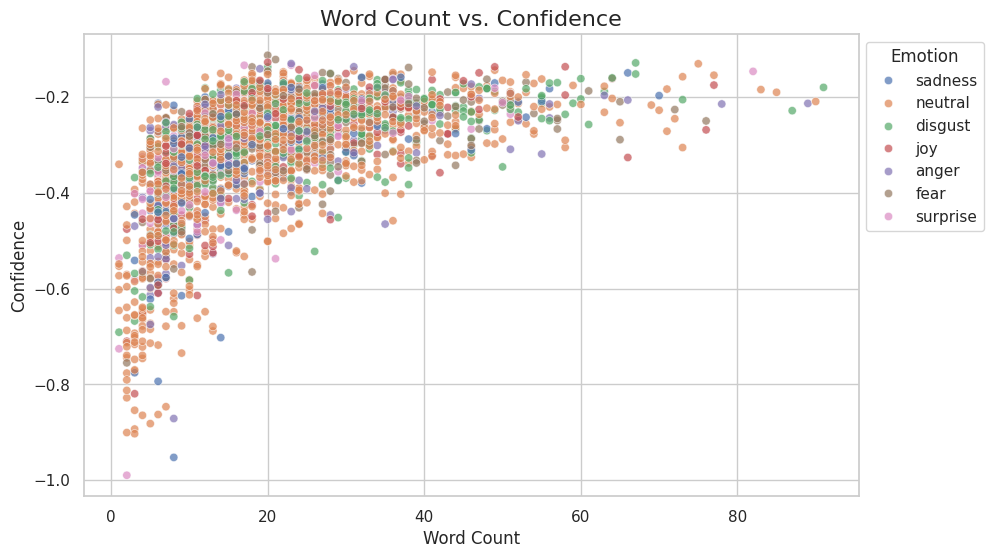

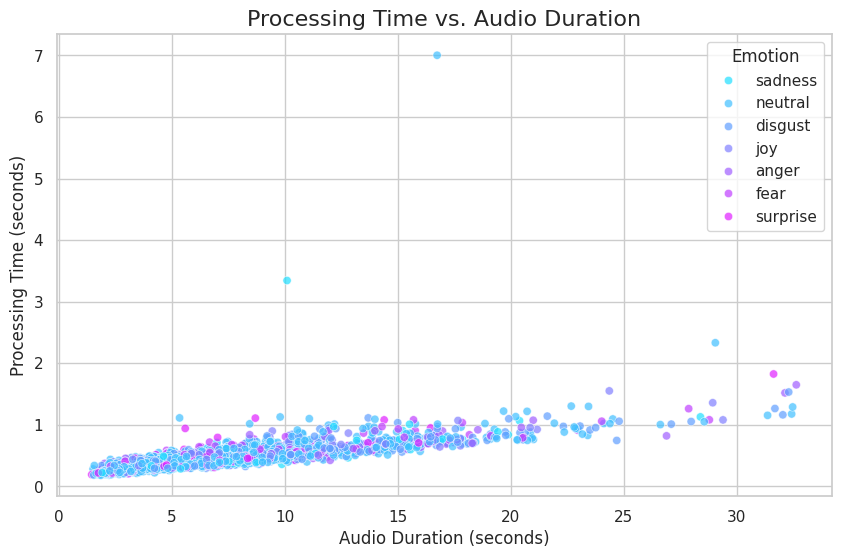

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/drive/MyDrive/transcription_results.csv'
data = pd.read_csv(file_path)

# Set visual style
sns.set_theme(style="whitegrid")

# Visualization 1: Distribution of Audio Durations
plt.figure(figsize=(10, 6))
sns.histplot(data['duration'], bins=30, kde=True, color='blue')
plt.title('Distribution of Audio Durations', fontsize=16)
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Visualization 2: Sentiment Polarity Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['polarity'], bins=30, kde=True, color='green')
plt.title('Distribution of Sentiment Polarity', fontsize=16)
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Visualization 3: Emotion Frequency
plt.figure(figsize=(12, 6))
emotion_counts = data['emotion'].value_counts()
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Frequency of Emotions', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Visualization 4: Relationship between Word Count and Confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='word_count', y='confidence', hue='emotion', palette='deep', alpha=0.7)
plt.title('Word Count vs. Confidence', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.legend(title='Emotion', bbox_to_anchor=(1, 1))
plt.show()

# Visualization 5: Processing Time vs. Audio Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='duration', y='time_taken', hue='emotion', palette='cool', alpha=0.7)
plt.title('Processing Time vs. Audio Duration', fontsize=16)
plt.xlabel('Audio Duration (seconds)', fontsize=12)
plt.ylabel('Processing Time (seconds)', fontsize=12)
plt.legend(title='Emotion', bbox_to_anchor=(1, 1))
plt.show()
